In [1]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import numpy as np

from learning_wavelets.data import im_generators
from learning_wavelets.evaluate import keras_psnr, keras_ssim
from learning_wavelets.image_utils import normalize_float_image, normalize_float_images
from learning_wavelets.learned_wavelet import learned_wavelet

Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
grey = True

In [5]:
run_id = 'learned_wavelet_div2k_30_1570806527'
epoch = 500
chkpt_path = f'../checkpoints/{run_id}-{epoch}.hdf5'
n_coarse = 3
if grey:
    n_coarse = 1
run_params = {
    'n_scales': 5, 
    'n_details': 256, 
    'n_coarse': n_coarse, 
    'n_groupping': 256,
}
size = None
model = learned_wavelet(input_size=(size, size, n_coarse), **run_params)
model.load_weights(chkpt_path)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
print(model.summary(line_length=110))

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                (None, None, None, 1)   0                                                 
______________________________________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, None, None, 1)   10           input_1[0][0]                        
______________________________________________________________________________________________________________
activation_2 (Activation)           (None, None, None, 1)   0            conv2d_2[0][0]                       
______________________________________________________________________________________________________________
average_pooling2d_1 (AveragePooling (None, None, None, 1)   0            activation_2[0][0]                   
_

# High passes filters visualization

In [7]:
high_passes_names = ['conv2d_1', 'conv2d_3','conv2d_5', 'conv2d_7', 'conv2d_9']

In [8]:
i_high = 1
high_passes_layer = model.get_layer(name=high_passes_names[i_high])

In [9]:
filters, biases = high_passes_layer.get_weights()

In [10]:
if n_coarse > 1:
    filters -= filters.min()
    filters /= filters.max()
else:
    filters /= np.abs(filters).max()

In [11]:
n_filters = 50
fig, axs = plt.subplots(n_filters, n_coarse, frameon=False, figsize=(n_coarse, n_filters))
for i in range(n_filters):
    for j in range(n_coarse):
        if n_coarse == 1:
            axs[i].imshow(filters[..., j, i], vmin=0, vmax=1)
            axs[i].axis('off')
        else:
            axs[i, j].imshow(filters[..., j, i], vmin=0, vmax=1)
            axs[i, j].axis('off')
plt.subplots_adjust(wspace=0.05, top=1, bottom=0)

<IPython.core.display.Javascript object>

In [12]:
high_passes_model = Model(model.input, high_passes_layer.output)

# Denoising noise

In [13]:
noise_mean = 0
noise_std = 30 / 255
size = (1, 256, 256, n_coarse)
noise = np.random.normal(loc=noise_mean, scale=noise_std, size=size)
noise_filtered = high_passes_model.predict_on_batch(noise)
denoised_noise = model.predict_on_batch(noise)

In [14]:
noise_min = noise.min()
noise -= noise_min
denoised_noise -= noise_min
noise_max = noise.max()
noise /= noise_max
denoised_noise /= noise_max
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(np.squeeze(noise))
axs[0].set_title('Noise, with sigma = 30')
axs[1].imshow(np.squeeze(denoised_noise))
axs[1].set_title('Output of learned wavelets')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Output of learned wavelets')

# Denoising image with a peak

In [15]:
%cd ..

/volatile/home/Zaccharie/workspace/understanding-unets


In [16]:
source = 'bsd68'
noise_std = 30
im_gen_train, im_gen_val, im_gen_test, size, n_samples_train = im_generators(
    source, 
    batch_size=1, 
    validation_split=0.1, 
    no_augment=True, 
    noise_std=noise_std,
    grey=grey
) 

In [17]:
sample_image_noisy, sample_image = im_gen_val[11]

In [18]:
sample_image.min(), sample_image.max()

(-1.6660073, 1.5979328)

In [19]:
sample_image.shape

(1, 496, 336, 1)

In [20]:
sample_image_peak = np.copy(sample_image)
sample_image_peak[0, 128, 128, :] = 100

In [21]:
denoised_sample_image = model.predict_on_batch(sample_image)
denoised_sample_image_peak = model.predict_on_batch(sample_image_peak)
max_denoised_sample_peak = np.max(denoised_sample_image_peak)

In [22]:
sample_image, sample_image_peak, denoised_sample_image, denoised_sample_image_peak = normalize_float_images(
    sample_image, 
    sample_image_peak,
    denoised_sample_image, 
    denoised_sample_image_peak,
)

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].imshow(np.squeeze(sample_image_peak))
axs[0].set_title('Original image with centered peak (value = 100)')
axs[1].imshow(np.squeeze(denoised_sample_image))
axs[1].set_title('Original image denoised')
axs[2].imshow(np.squeeze(denoised_sample_image_peak))
axs[2].set_title(f'Peaked image denoised (max value = {int(max_denoised_sample_peak)})')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Peaked image denoised (max value = 80)')

# Distribution of noise (correction of bias) before thresholding

In [38]:
hist_max = 2600
hist_min = 0
hist_range = (hist_min, hist_max)

<IPython.core.display.Javascript object>


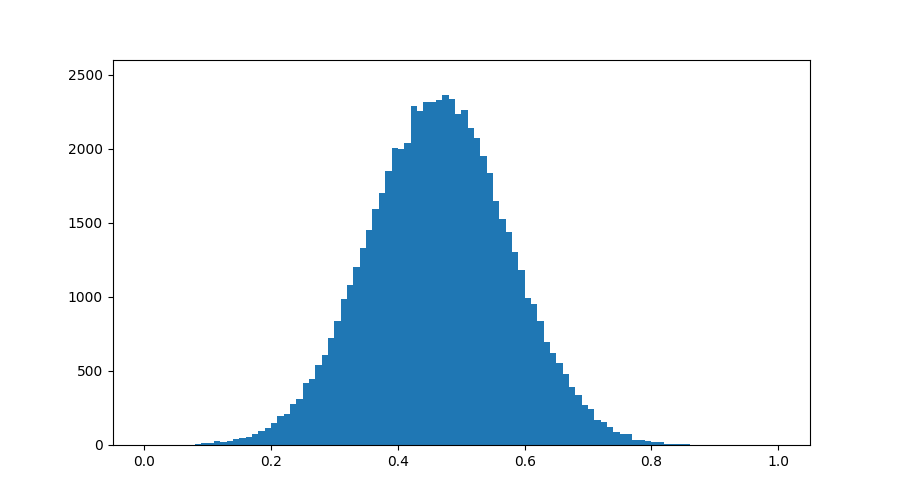

(0, 2600)

In [39]:
plt.figure()
plt.hist(np.mean(noise, axis=-1).flatten(), bins=100);
plt.ylim(hist_range)

In [25]:
len(np.where(noise_filtered >= 0)[0]) / noise_filtered.size

0.06839752197265625

In [40]:
len(np.where(noise >= 0)[0]) / noise.size

1.0

<IPython.core.display.Javascript object>


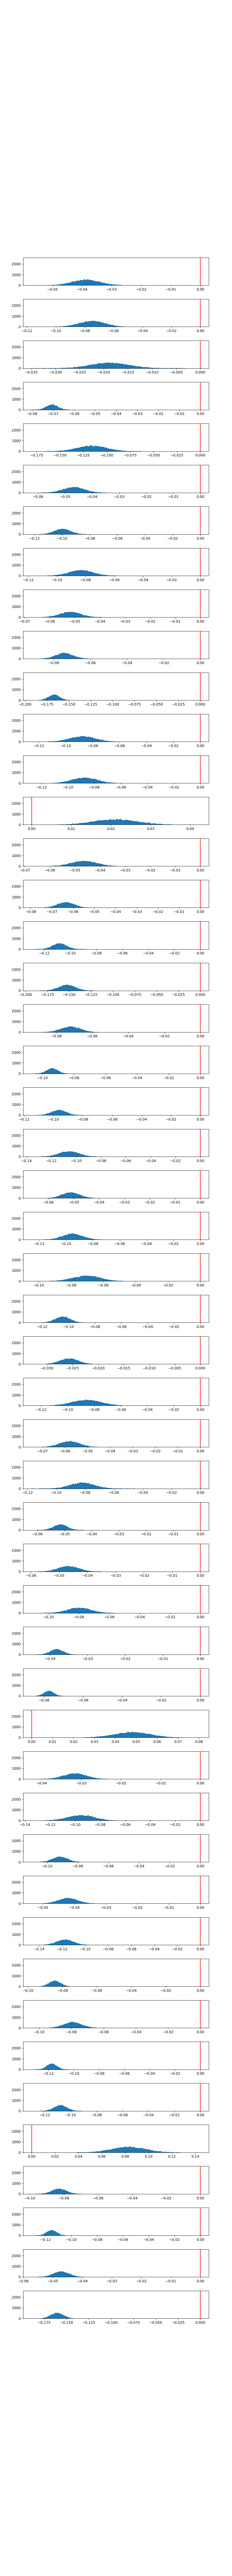

In [41]:
n_outputs = 50
fig, axs = plt.subplots(n_outputs, 1, frameon=False, figsize=(9, n_outputs*2))
for i in range(n_outputs):
    axs[i].hist(noise_filtered[..., i].flatten(), bins=100)
    axs[i].set_ylim(hist_range)
    axs[i].axvline(c='r')
#     axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.5, top=0.9, bottom=0.1, right=0.9, left=0.1)

In [28]:
n_outputs = 5
fig, axs = plt.subplots(n_outputs, 1, frameon=False, figsize=(9, n_outputs*5))
for i in range(n_outputs):
    axs[i].hist(noise_filtered[..., i].flatten() - biases[i], bins=100)
    axs[i].set_ylim(hist_range)
#     axs[i].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.5, top=0.9, bottom=0.1, right=0.9, left=0.1)

<IPython.core.display.Javascript object>

In [29]:
low_passes_names = ['conv2d_2', 'conv2d_4','conv2d_6', 'conv2d_8', 'conv2d_10']
# the last one is not decomposed

In [30]:
filters_norms = np.empty((len(high_passes_names),))
filters_means = list()
for i, high_pass_name in enumerate(high_passes_names):
    layer = model.get_layer(name=high_pass_name)
    weights, biases = layer.get_weights()
    filters_norms[i] = np.linalg.norm(weights)
#     from IPython.core.debugger import set_trace; set_trace()

    filters_means += list(np.mean(weights, axis=(0, 1, 2)))

In [31]:
len(filters_norms)

5

In [32]:
len(filters_means)

1280

In [33]:
plt.figure()
plt.hist(filters_means, bins=200)
plt.title('Distribution of the filter means across supposedly details scale')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution of the filter means across supposedly details scale')

# Low pass filters visualization

In [47]:
i_low = 0
low_pass_layer = model.get_layer(name=low_passes_names[i_low])

In [48]:
filters, biases = low_pass_layer.get_weights()

In [49]:
if n_coarse > 1:
    filters -= filters.min()
    filters /= filters.max()

<IPython.core.display.Javascript object>


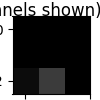

Text(0.5, 0.98, 'The first 1 filters (3 channels shown) of the 0-th coarse scale')

In [52]:
n_filters = min(n_coarse, 5)
fig, axs = plt.subplots(n_filters, n_coarse, frameon=False, figsize=(n_coarse, n_filters))
for i in range(n_filters):
    for j in range(n_coarse):
        if n_filters == 1:
            axs.imshow(filters[..., j, i], vmin=0, vmax=1)
        elif n_coarse == 1:
            axs[i].imshow(filters[..., j, i], vmin=0, vmax=1)
            axs[i].axis('off')
        else:
            axs[i, j].imshow(filters[..., j, i], vmin=0, vmax=1)
            axs[i, j].axis('off')
plt.subplots_adjust(wspace=0.05, top=0.9, bottom=0)
fig.suptitle(f'The first {n_filters} filters (3 channels shown) of the {i_low}-th coarse scale')